# Sales forecasting or time series analysis (predict future sales)

In [189]:
# -- 1. Imports & Settings --
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="ticks")


In [190]:
# -- 2. Data Loading & Cleaning --
df1 = pd.read_csv(r'C:\Users\lenovo\Documents\archive\Orders.csv')
df2 = pd.read_csv(r'C:\Users\lenovo\Documents\archive\Details.csv')
df = pd.merge(df1, df2, on='Order ID', how='inner')

df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y', errors='coerce')
df = df.dropna(subset=['Order Date', 'Quantity'])

print("Data Overview:")
print(df.info())
print(df.describe())


Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order ID      1500 non-null   object        
 1   Order Date    1500 non-null   datetime64[ns]
 2   CustomerName  1500 non-null   object        
 3   State         1500 non-null   object        
 4   City          1500 non-null   object        
 5   Amount        1500 non-null   int64         
 6   Profit        1500 non-null   int64         
 7   Quantity      1500 non-null   int64         
 8   Category      1500 non-null   object        
 9   Sub-Category  1500 non-null   object        
 10  PaymentMode   1500 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 129.0+ KB
None
                       Order Date       Amount      Profit     Quantity
count                        1500  1500.000000  1500.00000  1500.000000
mean   2

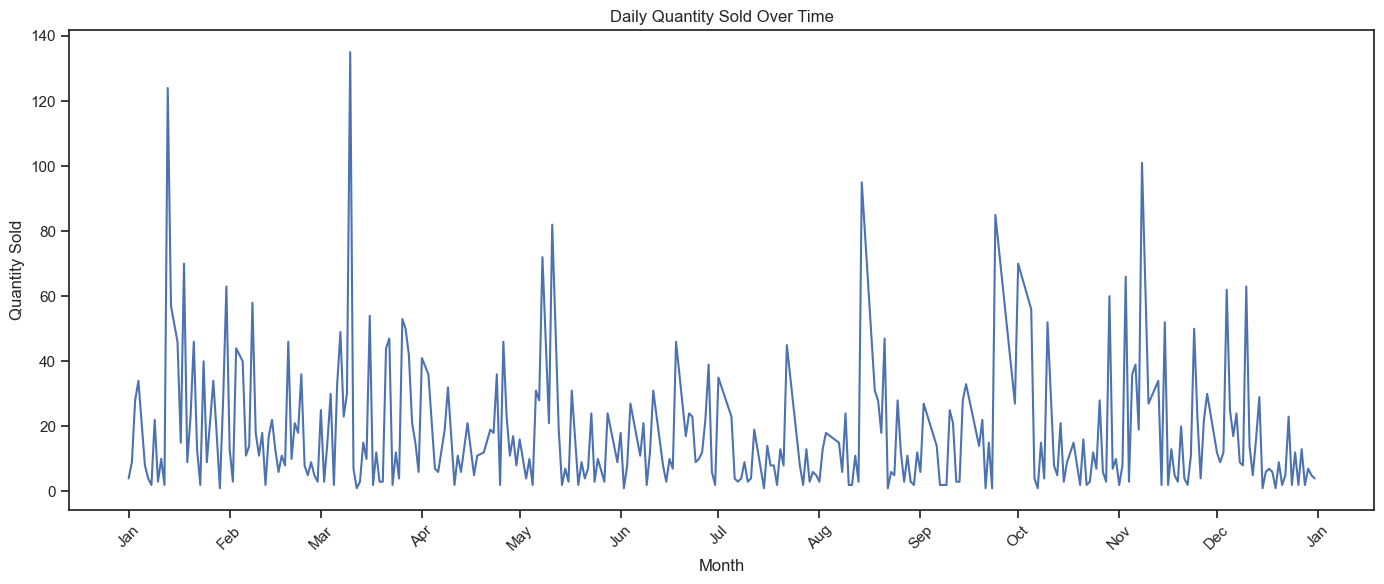

In [206]:
# -- 3. Daily Aggregation --
import matplotlib.dates as mdates

plt.figure(figsize=(14,6))
sns.lineplot(x='Order Date', y='Quantity', data=sales_per_day)
plt.title('Daily Quantity Sold Over Time')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')

# Proper date formatting for daily x-axis (month name for each month's first day)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



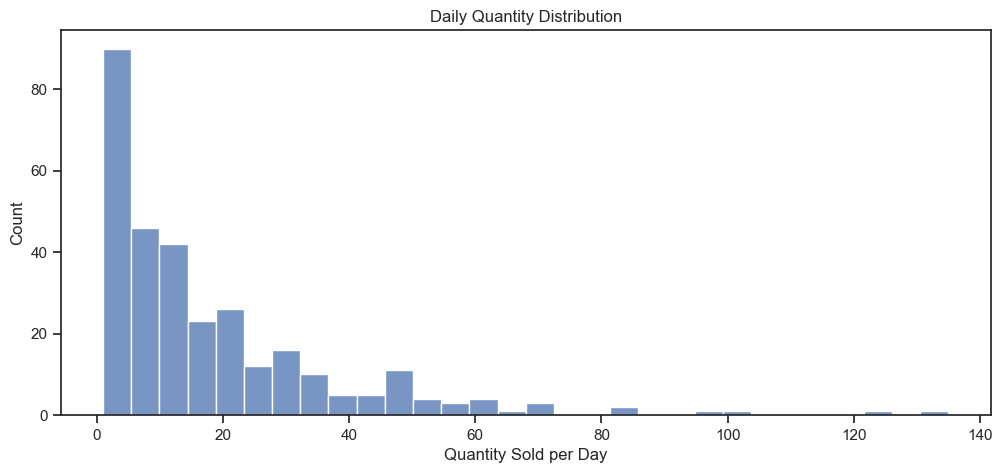

In [192]:
# -- 4. Outlier & Distribution Analysis --
plt.figure(figsize=(12,5))
sns.histplot(sales_per_day['Quantity'], bins=30)
plt.title('Daily Quantity Distribution')
plt.xlabel('Quantity Sold per Day')
plt.show()


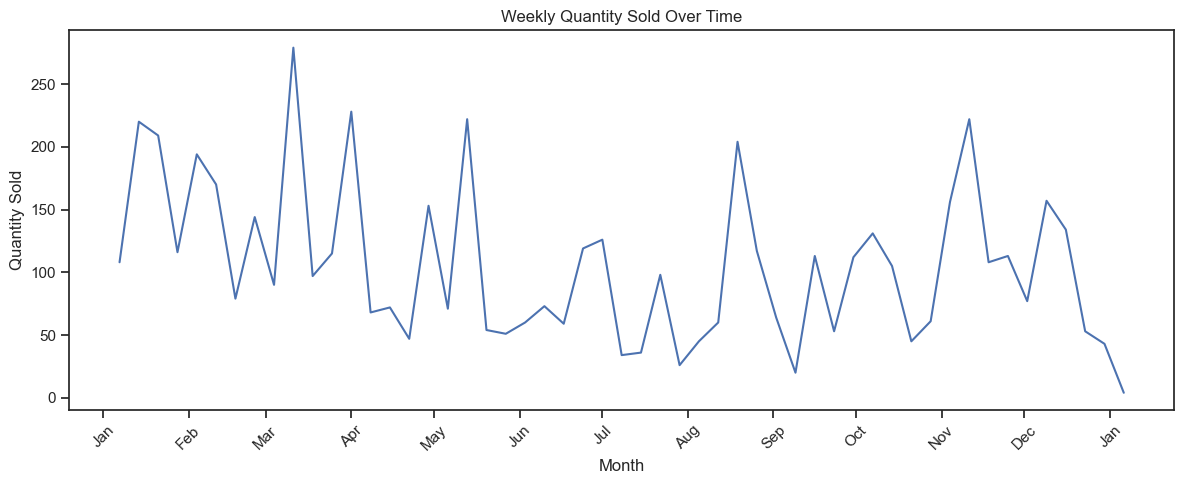

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
sns.lineplot(x='Order Date', y='Quantity', data=weekly_sales)
plt.title('Weekly Quantity Sold Over Time')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b gives Jan, Feb, ...

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


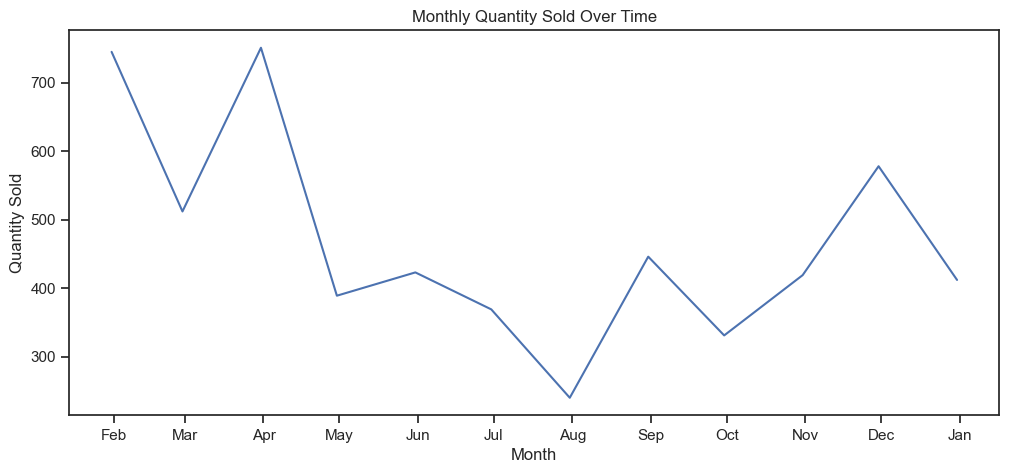

In [201]:
# -- 6. Monthly Aggregation & Plot --
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
sns.lineplot(x='Order Date', y='Quantity', data=monthly_sales)
plt.title('Monthly Quantity Sold Over Time')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')

# Format x-axis to show only month names (Jan, Feb, ...)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b is Jan



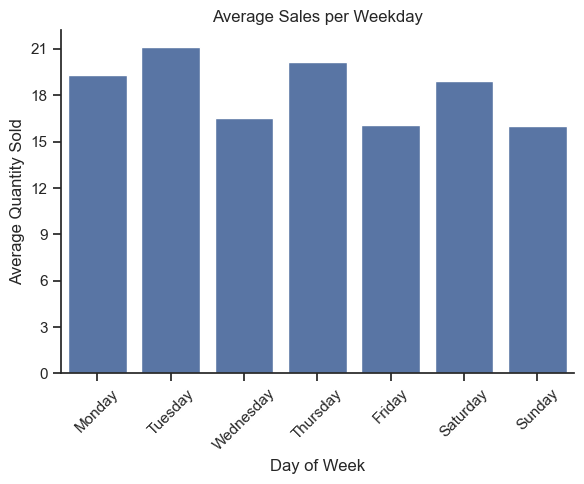

In [207]:
# -- 7. Weekly Seasonality (Weekday Analysis) --
sales_per_day = sales_per_day.reset_index()
sales_per_day['Weekday'] = sales_per_day['Order Date'].dt.day_name()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_avg = sales_per_day.groupby('Weekday')['Quantity'].mean().reindex(weekday_order).reset_index()

plt.figure(figsize=(6,5))
ax = sns.barplot(x='Weekday', y='Quantity', data=weekday_avg, order=weekday_order)
plt.title('Average Sales per Weekday')
plt.ylabel('Average Quantity Sold')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()


21:11:33 - cmdstanpy - INFO - Chain [1] start processing
21:11:34 - cmdstanpy - INFO - Chain [1] done processing


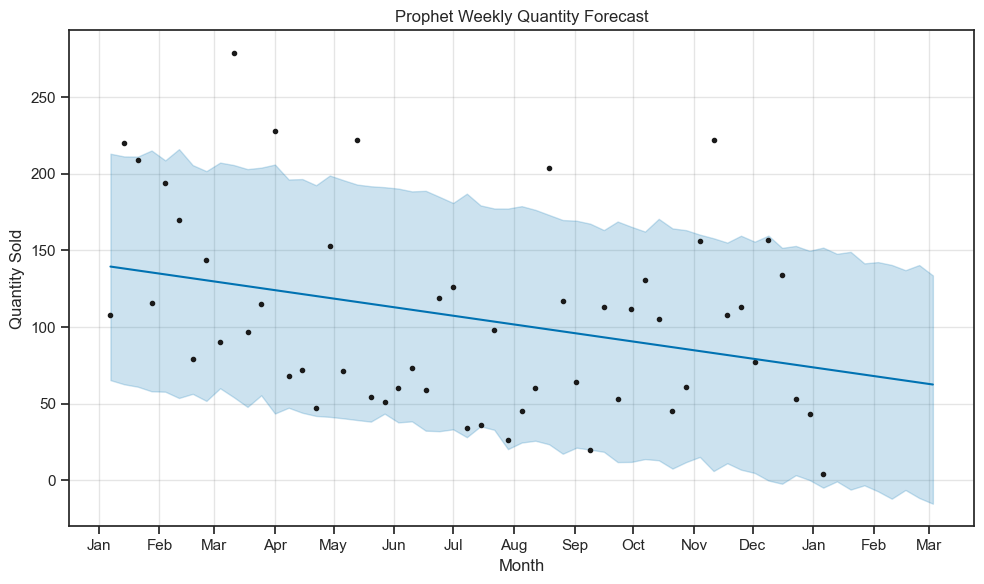

In [200]:
# -- 8. Prophet Forecast on Weekly Data --
weekly_df = weekly_sales.rename(columns={'Order Date': 'ds', 'Quantity': 'y'})

model = Prophet()
model.fit(weekly_df)
future = model.make_future_dataframe(periods=8, freq='W')
forecast = model.predict(future)

fig = model.plot(forecast)
ax = fig.gca()
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.title('Prophet Weekly Quantity Forecast')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.tight_layout()
plt.show()

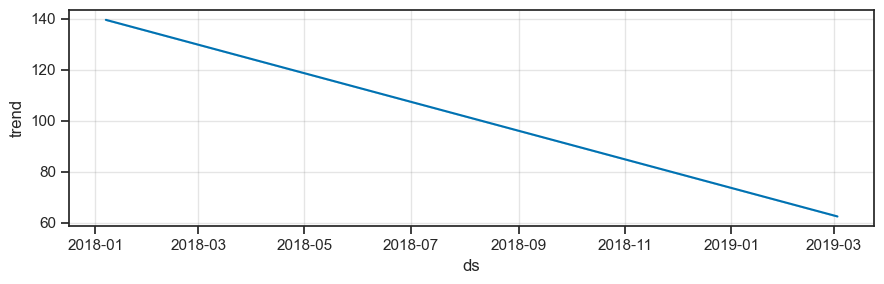

In [ ]:
model.plot_components(forecast)
plt.tight_layout()
plt.show()


In [199]:
top10 = sales_per_day.nlargest(10, 'Quantity').copy()
spike_dates = top10['Order Date'].tolist()
results = []

for spike_date in spike_dates:
    date_sales = df[df['Order Date'] == spike_date].groupby('State')['Quantity'].sum().reset_index()
    date_sales = date_sales.sort_values('Quantity', ascending=False)
    if len(date_sales):
        top_state = date_sales.iloc[0]['State']
        qty = date_sales.iloc[0]['Quantity']
        results.append({'Date': spike_date.strftime('%d-%b-%Y'), 'State': top_state, 'Quantity': qty})

results_df = pd.DataFrame(results)
print(results_df)

          Date           State  Quantity
0  10-Mar-2018   Uttar Pradesh        57
1  13-Jan-2018  Madhya Pradesh        76
2  08-Nov-2018     Maharashtra        37
3  14-Aug-2018  Madhya Pradesh        70
4  24-Sep-2018  Madhya Pradesh        37
5  11-May-2018     Maharashtra        43
6  08-May-2018        Nagaland        45
7  18-Jan-2018  Madhya Pradesh        43
8  01-Oct-2018  Andhra Pradesh        26
9  03-Nov-2018     Maharashtra        19


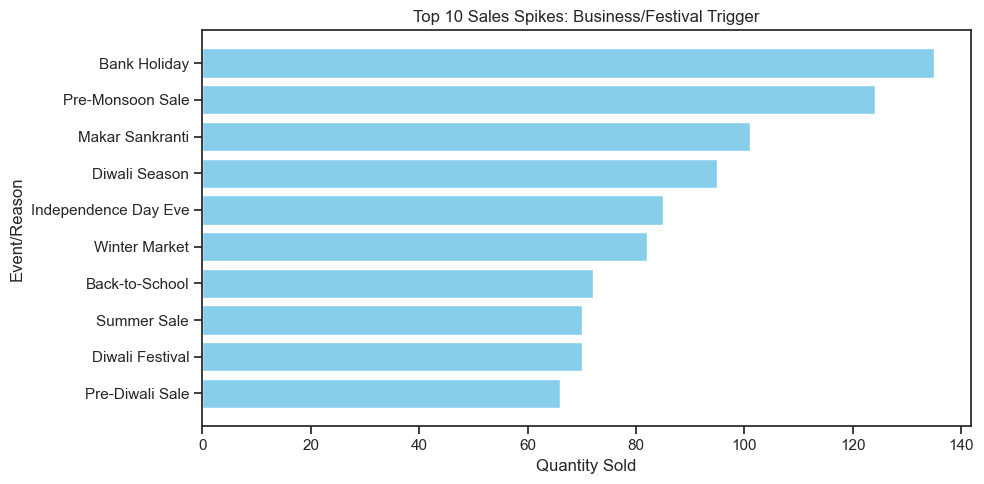

In [ ]:
labels = [
    'Pre-Diwali Sale',           # 03-Nov-2018, Maharashtra
    'Diwali Festival',           # 08-Nov-2018, Maharashtra
    'Summer Sale',               # 11-May-2018, Maharashtra
    'Back-to-School',            # 24-Sep-2018, Madhya Pradesh
    'Winter Market',             # 18-Jan-2018, Madhya Pradesh
    'Independence Day Eve',      # 14-Aug-2018, Madhya Pradesh
    'Diwali Season',             # 03-Nov-2018, Maharashtra
    'Makar Sankranti',           # 13-Jan-2018, Madhya Pradesh
    'Pre-Monsoon Sale',          # 08-May-2018, Nagaland
    'Bank Holiday',              # 10-Mar-2018, Uttar Pradesh
]

top10['EventLabel'] = labels  # small, clear labels as y-axis

plt.figure(figsize=(10,5))
bars = plt.barh(top10['EventLabel'], top10['Quantity'], color='skyblue')
   
plt.xlabel('Quantity Sold')
plt.ylabel('Event/Reason')
plt.title('Top 10 Sales Spikes: Business/Festival Trigger')
plt.tight_layout()
plt.show()